In [1]:
import pandas as pd
from dbgsom.dbgsom_ import DBGSOM
import seaborn.objects as so
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA, FactorAnalysis, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.impute import KNNImputer
from skimage.color import lab2rgb


In [2]:
data = pd.read_csv(
    "F:\Dokumente\git\data\CIC-Darknet2020\Darknet.CSV",
    index_col="Flow ID",
    parse_dates=["Timestamp"],
)


In [3]:
data.replace(
    {
        -np.inf: 0,
        np.inf: 0,
        "AUDIO-STREAMING": "Audio-Streaming",
        "File-transfer": "File-Transfer",
        "Video-streaming": "Video-Streaming",
    },
    inplace=True,
)
data.Timestamp = data.Timestamp.astype("int64")
X = data.drop(columns=["Label", "Label.1"])
y_1 = data["Label"]
y_2 = data["Label.1"]

X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X, y_1, y_2, random_state=23, stratify=y_2
)


In [4]:
scaler = PowerTransformer()
# scaler = StandardScaler()
imputer = KNNImputer(add_indicator=True)
ohe = OneHotEncoder(max_categories=10, handle_unknown="infrequent_if_exist")
col_transformer = ColumnTransformer(
    transformers=[
        ("ohe", ohe, ["Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
som = DBGSOM(
    max_epochs=100,
    random_state=32,
    spreading_factor=1.5,
    max_neurons=100,
    # decay_function="linear",
    # sigma_end=0.3,
    vertical_growth=True,
    growth_criterion="entropy",
    min_samples_vertical_growth=200,
)

pipe = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("som", som),
    ]
)

# y_train = y_1_train
y_train = y_2_train


In [5]:
pipe.fit(X_train, y_train)


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 61%|██████    | 61/100 [00:01<00:00, 46.16 epochs/s]


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=10),
                                                  ['Src IP', 'Src Port',
                                                   'Dst IP', 'Dst Port',
                                                   'Protocol'])],
                                   verbose_feature_names_out=False)),
                ('imputer', KNNImputer(add_indicator=True)),
                ('scaler', PowerTransformer()),
                ('som',
                 DBGSOM(growth_criterion='entropy', max_epochs=100,
                        min_samples_vertical_growth=200, random_state=32,
                        spreading_factor=1.5, vertical_growth=True))])

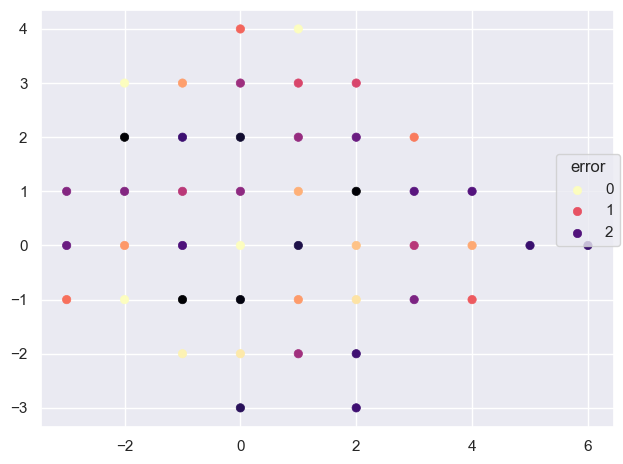

In [6]:
som.plot(
    color="error",
    # palette="Set1",
    # pointsize="average_distance",
)
# som.plot(
#     color="label",
#     palette="Set1",
#     pointsize="average_distance",
# )


In [7]:
weights = pd.DataFrame.from_dict(dict(som.som_.nodes)).T.set_index(
    np.arange(len(som.som_.nodes))
)["weight"]

weights_split = pd.DataFrame((pd.Series(feature) for feature in weights)).drop(
    120, axis=1
)
weights_split.columns = col_transformer.get_feature_names_out()


In [8]:
pca = PCA(
    n_components=3,
    # rotation="varimax",
)
pca_components = pca.fit_transform(
    X=weights_split,
    # y=pd.DataFrame(dict(som.som_.nodes.data())).T.label.astype(np.int32),
)


In [9]:
colors_lab = pca_components
colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (0, 100))
colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-128, 127))
colors_lab[:, 2] = minmax_scale(colors_lab[:, 2], (-128, 127))

colors_rgb = lab2rgb(colors_lab)


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return func(*args, **kwargs)


<Axes: >

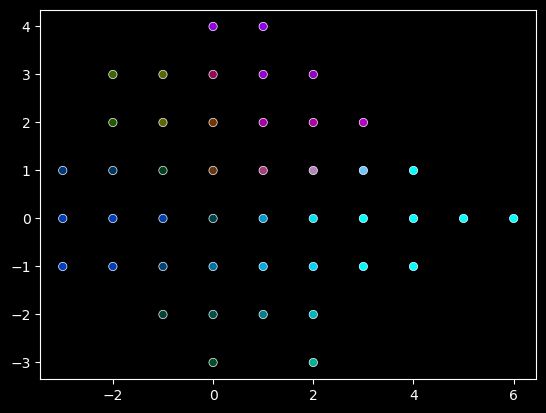

In [10]:
sns.scatterplot(
    x=np.array(som.som_.nodes)[:, 0],
    y=np.array(som.som_.nodes)[:, 1],
    # style=som.classes_[np.array(list(dict(som.som_.nodes.data("label")).values()))],
    # color=minmax_scale(pca_components),
    color=colors_rgb,
    # c=weights_split["Average Packet Size"],
    # legend="full",
    # size=pd.DataFrame(dict(som.som_.nodes.data())).T.error #> som.growing_threshold_,
)


In [11]:
print(f"Topographic error: {som.topographic_error_}")

print(f"Accuracy: {pipe.score(X_test, y_2_test)}")

print(
    f"""F1 score: {f1_score(
    y_2_test,
    pipe.predict(X_test),
    average="macro"
    )
}"""
)

print(f"Growing Threshold: {som.growing_threshold_}")


Topographic error: 0.04570077345567939
Accuracy: 0.7384054489444083
F1 score: 0.5171880057100003
Growing Threshold: 1.5


In [12]:
# so.Plot(
#     np.array(som.som_.nodes)[:, 0], np.array(som.som_.nodes)[:, 1], color=colors_tuple
# ).add(so.Dots()).scale()


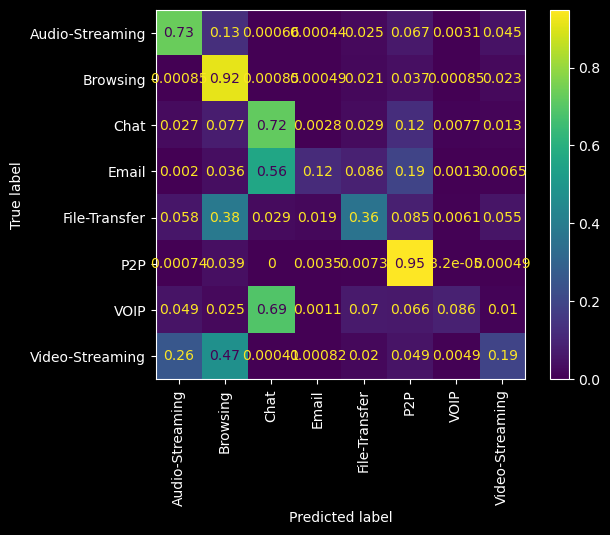

In [13]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_2_test,
    pipe.predict(X_test),
    normalize="true",
    xticks_rotation="vertical",
    # values_format="f{.3}"
)


In [14]:
len(som.neurons_)


45